In [27]:
#0. Load Modules
import os
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

#1. Define Functions 

#Define Filter Function
def filterSyntheticEEG(EEG):
    #Bandpass
    w = [x / 100 for x in [0.1, 30]]
    b, a = signal.butter(4, w, 'band')
    
    #Notch
    b_notch, a_notch = signal.iirnotch(60, 30, 500)

    #Process
    tempFilteredEEG = [signal.filtfilt(b, a, EEG[trial,:]) for trial in range(len(EEG))]
    filteredEEG = [signal.filtfilt(b_notch, a_notch, tempFilteredEEG[trial]) for trial in range(len(EEG))]
    
    return filteredEEG

#Define Baseline Function
def baselineCorrect(EEG):
    #Baseline
    baselineRange = [0, 20]

    #process
    baselinedEEG = [(EEG[trial] - (np.mean(EEG[trial][baselineRange[0]:baselineRange[1]]))) for trial in range(len(EEG))]

    return baselinedEEG

#Define Resample Function
def resampleEEG(EEG):
    #Define function
    def interpolateArray(EEGTrial):
        interpModel = interp1d(np.arange(1,101), EEGTrial, fill_value='extrapolate')
        resampledEEG = interpModel(np.arange(1,101,100/600))
        return resampledEEG

    #Process
    resampleEEG = [interpolateArray(EEG[trial]) for trial in range(len(EEG))]

    return resampleEEG

def downsampleEEG(EEG):
    #Define function
    def interpolateArray(EEGTrial):
        interpModel = interp1d(np.arange(1,601), EEGTrial, fill_value='extrapolate')
        resampledEEG = interpModel(np.arange(1,601,600/100))
        return resampledEEG

    #Process
    resampleEEG = [interpolateArray(EEG[trial]) for trial in range(len(EEG))]

    return np.array(resampleEEG)

#2. Load EEG Data
EEGData = np.genfromtxt('data/ganTrialERP.csv', delimiter=',', skip_header=1)[:,1:]
EEGData = np.delete(EEGData, 1, 1) #Uneeded Column
#EEGData[:,1:] = filterSyntheticEEG(EEGData[:,1:]) 
EEGID = EEGData[:,0]
tempEEG = np.array(downsampleEEG(EEGData[:,1:]))
EEGData = np.insert(tempEEG, 0, EEGData[:,0], axis=1)
EEGData[:,1:] = filterSyntheticEEG(EEGData[:,1:])

lossEEGData = EEGData[np.r_[EEGData[:,0]==0],1:]
winEEGData = EEGData[np.r_[EEGData[:,0]==1],1:]


#3. Load and Process Synthetic Data
synData = np.genfromtxt('generated_samples/Old/sd_len100_30000ep.csv', delimiter=',', skip_header=1)

#Process synthetic data
tempSynData = filterSyntheticEEG(synData[:,1:])
#tempSynData = [synData[trial,1:] for trial in range(len(synData))]
tempSynData = baselineCorrect(tempSynData)
#tempSynData = resampleEEG(tempSynData) 

#Create new array for processed synthetic data
processedSynData = np.zeros((len(tempSynData),101))
processedSynData[:,0] = synData[:,0]
processedSynData[:,1:] = np.array(tempSynData)

lossSynData = processedSynData[np.r_[processedSynData[:,0]==0],1:]
winSynData = processedSynData[np.r_[processedSynData[:,0]==1],1:]

avgLossSynData = np.mean(lossSynData, axis=0)
avgWinSynData = np.mean(winSynData, axis=0)

#Scale synthetic data 
EEGDataScale = np.max(np.mean(lossEEGData, axis=0))-np.min(np.mean(lossEEGData, axis=0))
EEGDataOffset = np.min(np.mean(lossEEGData, axis=0))
synDataScale = np.max(avgLossSynData)-np.min(avgLossSynData)
synDataOffset = np.min(avgLossSynData)

avgLossSynData = (((avgLossSynData-synDataOffset)/synDataScale)*EEGDataScale)+EEGDataOffset
avgWinSynData = (((avgWinSynData-synDataOffset)/synDataScale)*EEGDataScale)+EEGDataOffset

print('Data loading complete!')

Data loading complete!


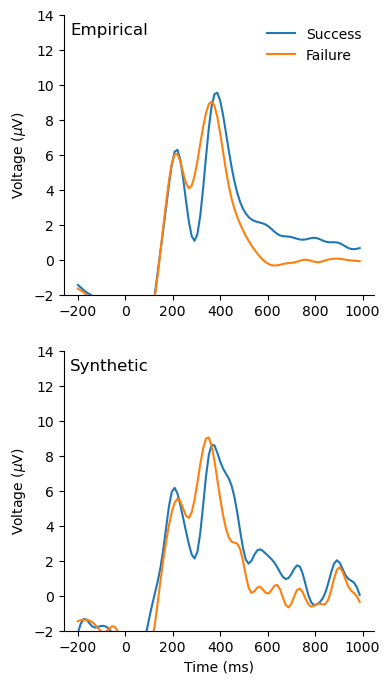

In [28]:
#4. Plot ERPs
time = np.arange(-200, 1000, 12)

ax1 = plt.subplot(2,1,1)
plt.plot(time, np.mean(winEEGData, axis=0))
plt.plot(time, np.mean(lossEEGData, axis=0))
plt.ylabel(r'Voltage ($\mu$V)')
plt.title('Empirical', loc = 'left', x = .02, y=.9)
plt.ylim((-2,14))
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax1.legend(['Success', 'Failure'],frameon=False)

ax2 = plt.subplot(2,1,2)
plt.plot(time, avgWinSynData)
plt.plot(time, avgLossSynData)
plt.ylabel(r'Voltage ($\mu$V)')
plt.xlabel('Time (ms)')
plt.title('Synthetic', loc = 'left', x = .02, y=.9)
plt.ylim((-2,14))
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)

fig = plt.gcf()
fig.set_size_inches(4, 8)
fig.savefig('Proposal Figure 1.png', dpi=600)

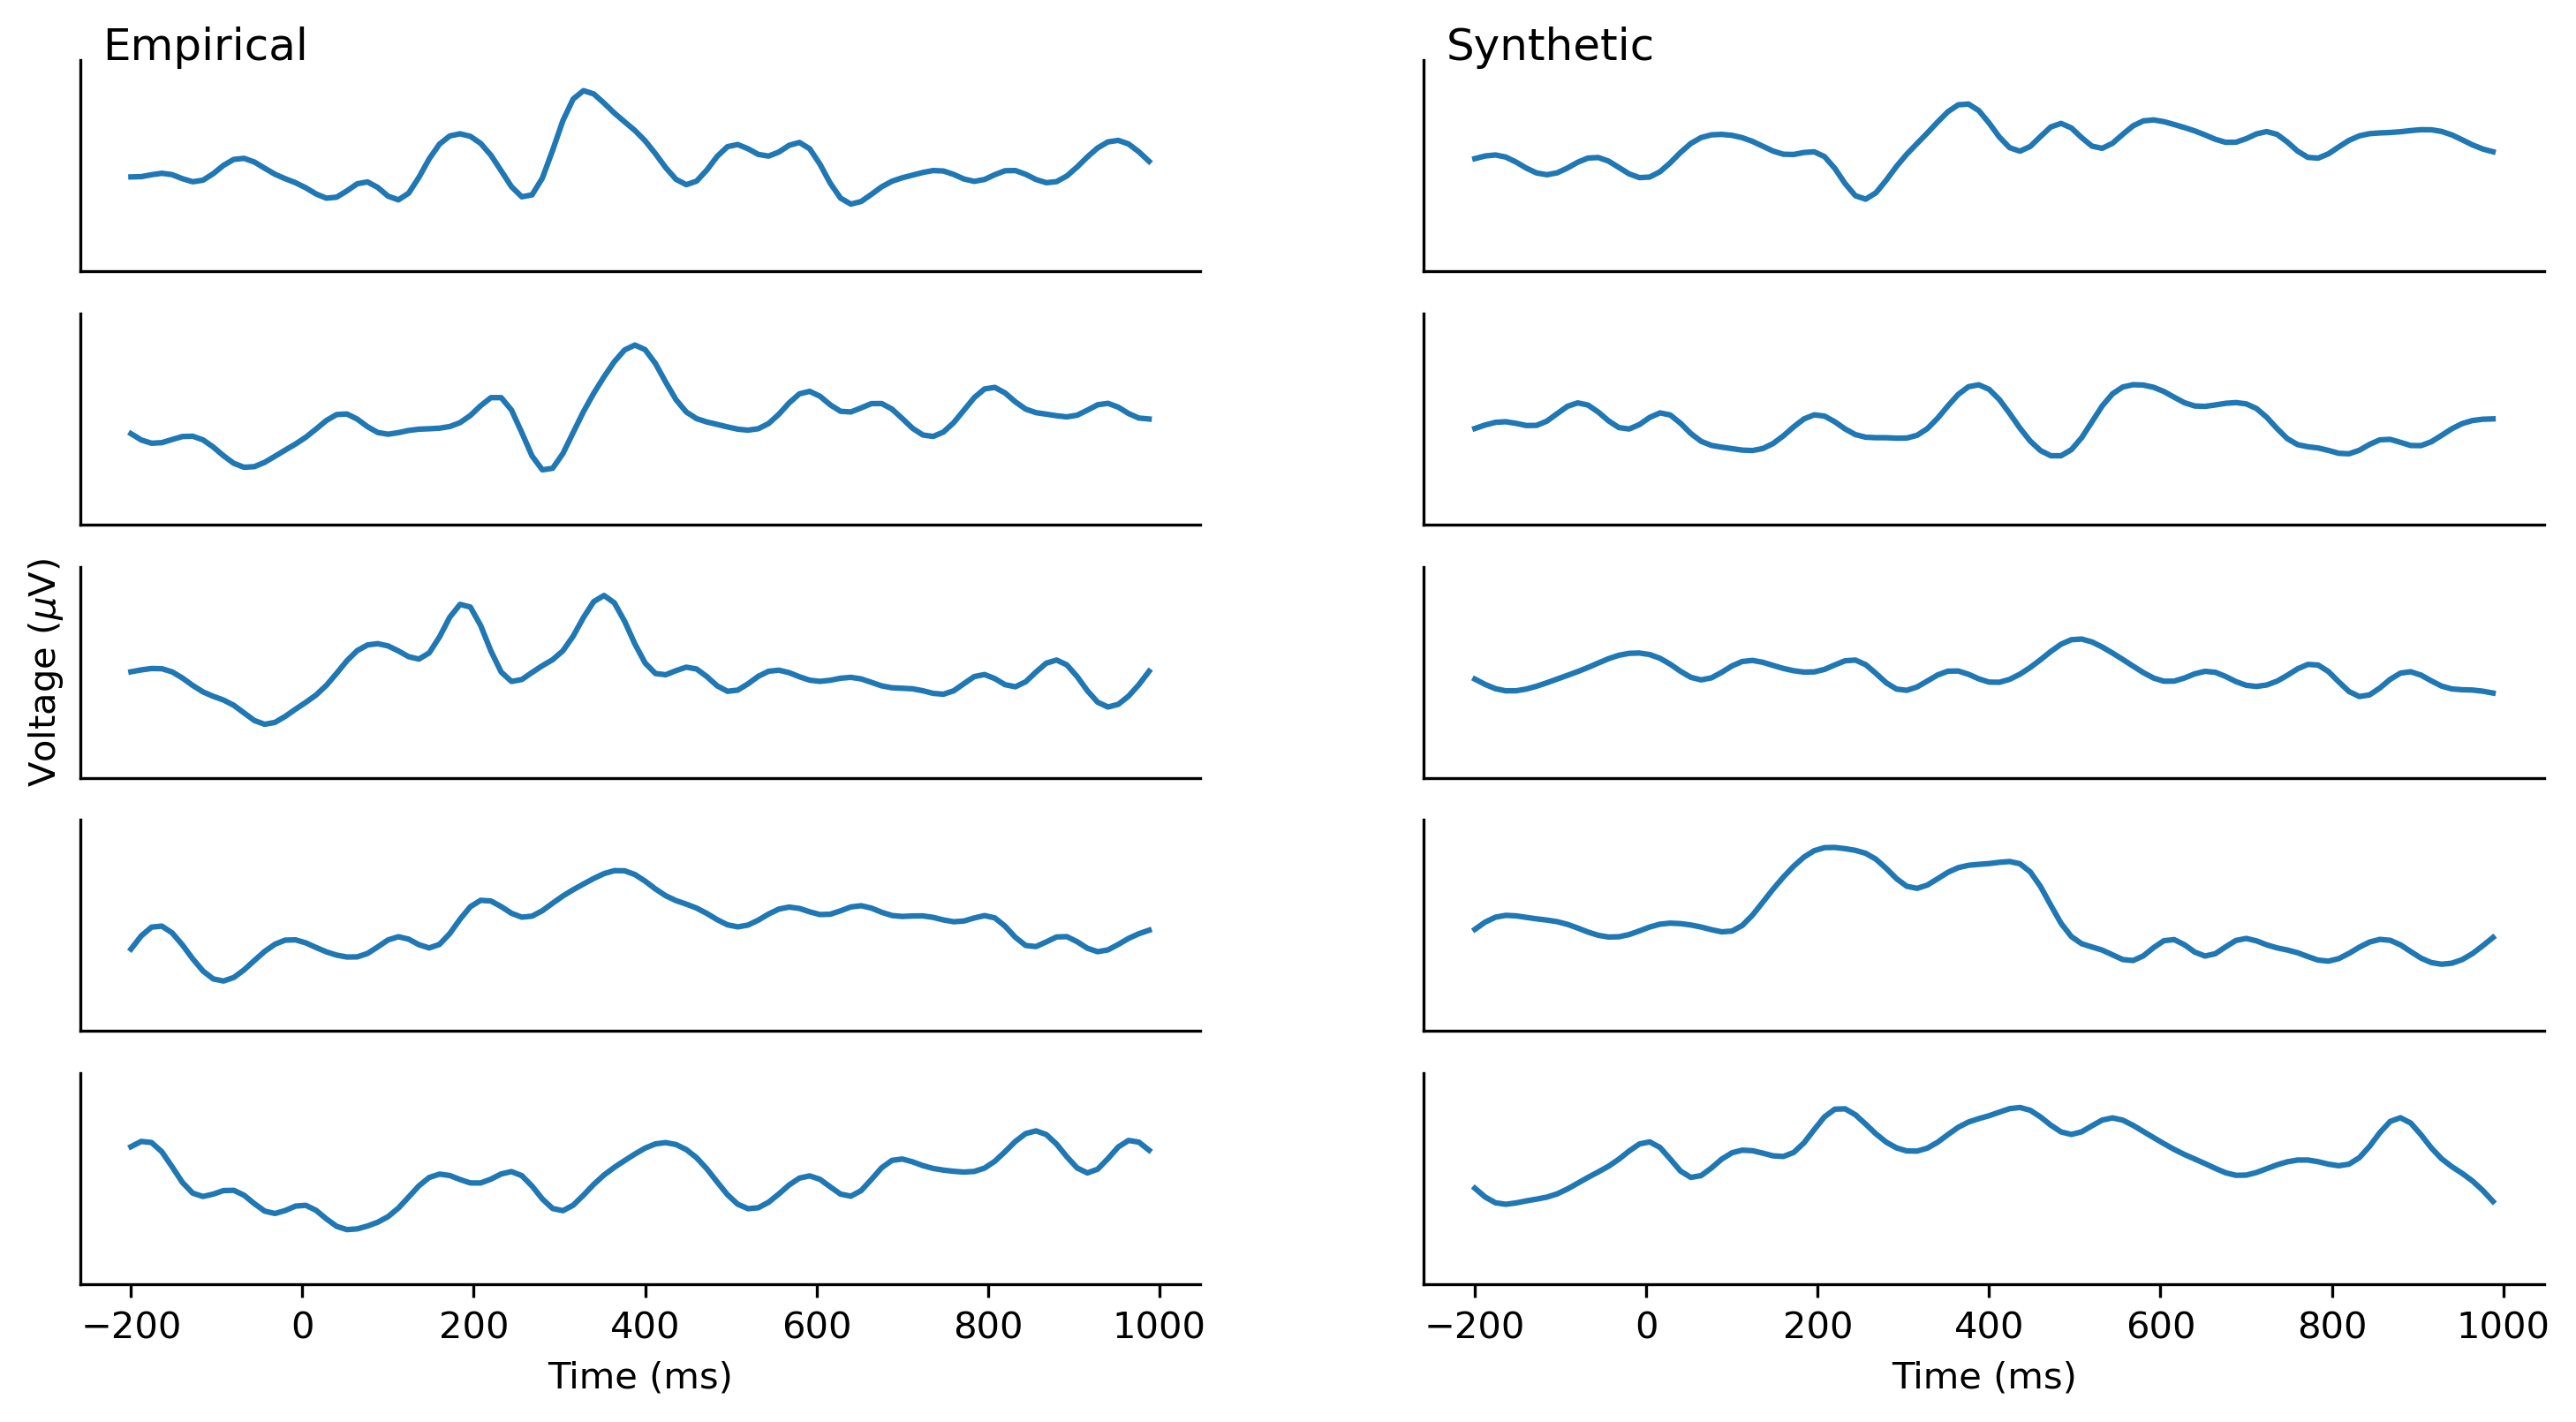

In [29]:
plt.figure(figsize=(12, 6), dpi=300)
time = np.arange(-200, 1000, 12)

x=1
for counter in range(5):
    ax1 = plt.subplot(5,2,x)
    plt.plot(time, winEEGData[counter*20,:]-np.mean(winEEGData[counter*20,:]))
    if counter == 2:
        plt.ylabel(r'Voltage ($\mu$V)')
    if counter == 0:
        plt.title('Empirical', loc = 'left', x = .02, y=.9)
    plt.ylim((-45,45))
    ax1.spines.right.set_visible(False)
    ax1.spines.top.set_visible(False)
    if counter != 4:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
    else:
        plt.xlabel('Time (ms)')
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
    
    ax1 = plt.subplot(5,2,x+1)
    plt.plot(time, winSynData[counter*20,:])
    if counter == 0:
        plt.title('Synthetic', loc = 'left', x = .02, y=.9)
    plt.ylim((-.3,.3))
    ax1.spines.right.set_visible(False)
    ax1.spines.top.set_visible(False)
    if counter != 4:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
    else:
        plt.xlabel('Time (ms)')
        #plt.xticks(np.arange(-200,1201,200))
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
    
    x+=2
    
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('Trial Figure 1.png', dpi=600)

In [ ]:
pcaData = np.genfromtxt('data/pca_results.csv', delimiter=',', skip_header=1)

ax = plt.subplot(1,1,1)
plt.plot(pcaData[:,0],pcaData[:,1],'o',alpha=0.15, markersize=5)
plt.plot(pcaData[:,2],pcaData[:,3],'o',alpha=0.15, markersize=5)
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.rcParams.update({'font.size': 10})
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.legend(['Empirical', 'Synthetic'])
plt.tight_layout()
plt.subplots_adjust(left=0.2, right = 1, bottom = .2, top = 1)

fig = plt.gcf()
fig.set_size_inches(4, 4)
fig.savefig('Proposal Figure 2.png', dpi=300)

In [ ]:
#4. Plot ERPs
avgChunks = [10, 100, 500, 1000, 5000, 10000]
for x, i in enumerate(avgChunks):
    avgLossSynData = np.mean(lossSynData[0:i,:], axis=0)
    avgWinSynData = np.mean(winSynData[0:i,:], axis=0)

    #Scale synthetic data 
    EEGDataScale = np.max(np.mean(lossEEGData, axis=0))-np.min(np.mean(lossEEGData, axis=0))
    EEGDataOffset = np.min(np.mean(lossEEGData, axis=0))
    synDataScale = np.max(avgLossSynData)-np.min(avgLossSynData)
    synDataOffset = np.min(avgLossSynData)

    avgLossSynData = (((avgLossSynData-synDataOffset)/synDataScale)*EEGDataScale)+EEGDataOffset
    avgWinSynData = (((avgWinSynData-synDataOffset)/synDataScale)*EEGDataScale)+EEGDataOffset


    time = np.arange(-200, 1000, 2)

    ax2 = plt.subplot(3,2,x+1)
    plt.plot(time, avgWinSynData)
    plt.plot(time, avgLossSynData)
    plt.ylabel(r'Voltage ($\mu$V)')
    plt.xlabel('Time (ms)')
    plt.title('Synthetic', loc = 'left', x = .02, y=.9)
    plt.ylim((-2,14))
    ax2.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)

    fig = plt.gcf()
    fig.set_size_inches(4, 8)
    fig.savefig('Proposal Figure 1.png', dpi=300)